In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
import pandas as pd
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# View Measurement data to understand the table & data structure
measurement_df = pd.read_sql("SELECT * FROM measurement", conn)
measurement_df.head(10)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


In [8]:
# View Station data to understand the table & data structure
station_df = pd.read_sql("SELECT * FROM station", conn)
station_df.head(10)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [9]:
# Save references to each table
# Map Measurement class
Measurement = Base.classes.measurement
# Map Station class
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(current_date)
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= year_ago_date).filter(
    Measurement.date <= current_date[0]).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(results, columns=['date', 'prcp'])
# Sort the dataframe by date
climate_df.sort_values(by=['date'])
climate_df.head(10)

('2017-08-23',)


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
5,2016-08-23,1.79
6,2016-08-23,0.70
7,2016-08-24,0.08
8,2016-08-24,2.15
9,2016-08-24,2.28


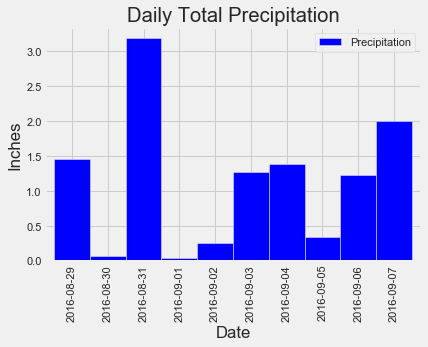

In [38]:
# Perform a query to retrieve precipitation scores for a 10 day vacation period
results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= "2016-08-29").filter(
    Measurement.date <= "2016-09-07").order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
vacation_df = pd.DataFrame(results, columns=['date', 'prcp'])

# drop null records. group by date. sum daily total precipitation
vacation_df.dropna(subset=['prcp'], inplace=True)
vacation_data = vacation_df.groupby(["date"])
total_prcp = vacation_data["prcp"].sum()

# creating new dataframe for charts
vacation_bar_chart = pd.DataFrame({
    "Precipitation": total_prcp
})

# display dataframe as point of reference
vacation_bar_chart
group_keys = list(vacation_data.groups.keys())
vacation_bar_chart_panda = pd.DataFrame({'x_axis':group_keys, 'Precipitation':total_prcp})
vacation_bar_chart_panda.plot.bar(x='x_axis', y='Precipitation', color='blue', width=1, rot=90);

# Adding axis labels
_=plt.title("Daily Total Precipitation")
_=plt.xlabel("Date")
_=plt.ylabel("Inches")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
rows = session.query(func.count(Station.id)).scalar()
print(f"Total number of Stations: {rows}")

Total number of Stations: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
results = session.query(Measurement.station, func.count(Measurement.station)).group_by(
    Measurement.station).order_by(
    func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
active_station_df = pd.DataFrame(results, columns=['Station Name', 'Total Rows'])
active_station_df.set_index('Station Name', inplace=True, )
active_station_df.head(10)

,Total Rows
Station Name,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
# Print the station with highest number of observations
station_id = [x[0] for x in results[:1]][0]
print(f'{[x[0] for x in results[:1]][0]} has highest number of observations of {[x[1] for x in results[:1]][0]}')

USC00519281 has highest number of observations of 2772


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station==station_id).all()
lowest_temp = [x[1] for x in lowest[:1]][0]
highest = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station==station_id).all()
highest_temp = [x[1] for x in highest[:1]][0]
average = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station==station_id).all()
average_temp = [x[1] for x in average[:1]][0]
print(f'Various Temparature Records for Station: {station_id}')
print(f'Lowest: {lowest_temp}')
print(f'Highest: {highest_temp}')
print(f'Average: {round(average_temp, 2)}')

Various Temparature Records for Station: USC00519281
Lowest: 54.0
Highest: 85.0
Average: 71.66


In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(current_date)
year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.tobs).filter(
    Measurement.date >= year_ago_date).filter(
    Measurement.date <= current_date[0]).filter(
    Measurement.station==station_id).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
temperature_df = pd.DataFrame(results, columns=['Temperature'])
# Sort the dataframe by Temparature
temperature_df.sort_values(by=['Temperature'])
temperature_df.head(5)

('2017-08-23',)


,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


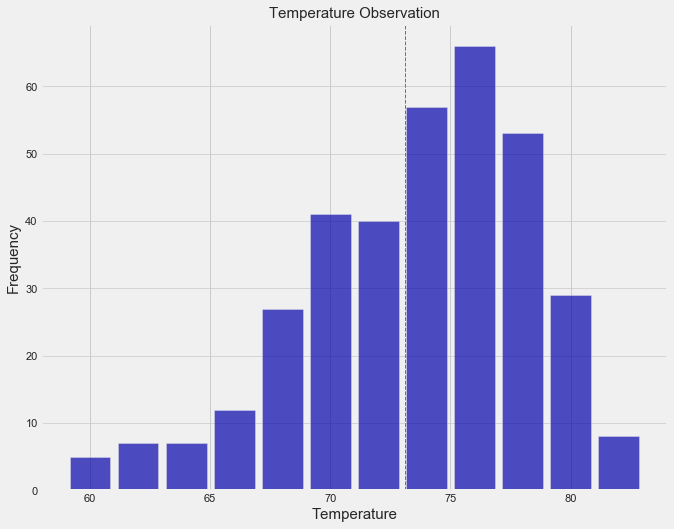

In [51]:
# Plotting the Histogram
plt.style.use('fivethirtyeight')
plt.figure(figsize=[10,8])
_= plt.hist(temperature_df['Temperature'], bins=12, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.axvline(temperature_df['Temperature'].mean(), color='r', linestyle='dashed', linewidth=1, label="Avg. Temperature")
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Temperature Observation',fontsize=15)
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
